In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

df = pd.read_csv('./ErrorLog/errorlog0606_0612_edit_ver2.csv')
df.fillna('', inplace = True)   # 空值補 ''

print('Shape of the raw data: ', df.shape)

df.head(10)

Shape of the raw data:  (1005409, 16)


,EventTime,SessionID,UserID,ErrorEventID,Channel,Country,LV,VipLV,UDID,State,Machine,TotalBet,FeverState,PublishVer,CurChannel,IPCountry
0,1591694027,a98efd7aa8e5ca901f689caeee448a05,2.020100e+15,31419999,1,TW,999,8,"""49242BA5-2C92-43A9-A9AA-BB60517A0C2A""",,,,,,,
1,1591753912,c1c93c76a1273b6aa12751e3303e3db1,2.020100e+15,6001,1,CN,33,1,"""8FE31F29-49E0-4B64-BBBC-D9877C292968""",,,,,,,
2,1591753971,c1c93c76a1273b6aa12751e3303e3db1,2.020100e+15,9002,1,CN,33,1,"""8FE31F29-49E0-4B64-BBBC-D9877C292968""",,,,,,,
3,1591768171,"""""",2.020100e+15,2101,1,TW,1,0,"""C855F6DF-DA1A-4CCC-AC12-AA5574509E67""",,,,,,,
4,1591777553,8a6182354acf11f4bd71873be47778b4,2.020100e+15,6001,2,TW,999,8,13085a98dfaa3816,,,,,,,
5,1591711516,3d876fc03ce99a14ed5e71c0d7cb90e5,2.020100e+15,6001,2,TW,397,4,38d547b02d5d3710,,,,,,,
6,1591753763,6bc29aa385300d91541ced10f2061ad7,2.020100e+15,9002,1,TW,1000,8,"""3E1FFF13-AE55-4300-B66D-6CC18F673CF4""",,,,,,,
7,1591753737,6bc29aa385300d91541ced10f2061ad7,2.020100e+15,9002,1,TW,1000,8,"""3E1FFF13-AE55-4300-B66D-6CC18F673CF4""",,,,,,,
8,1591753711,6bc29aa385300d91541ced10f2061ad7,2.020100e+15,6001,1,TW,1000,8,"""3E1FFF13-AE55-4300-B66D-6CC18F673CF4""",,,,,,,
9,1591757540,3d116d8dacadac0094153cbab0bf7ceb,2.020100e+15,2254,1,TW,1000,8,"""3E1FFF13-AE55-4300-B66D-6CC18F673CF4""",,,,,,,


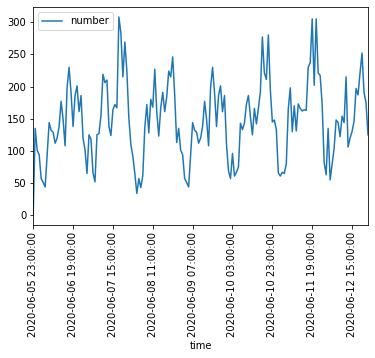

In [4]:
%matplotlib inline
from pandas.core.frame import DataFrame
from datetime import datetime

TW_EventTime = df.loc[df['IPCountry'] == "TW"]['EventTime']

date_time = []
for _time in TW_EventTime:
    dt = datetime.fromtimestamp(_time)

    # -----------------------將異常資料去除
    temp_time = str(datetime(dt.year, dt.month, dt.day))
    if temp_time == '2020-06-09 00:00:00':
        continue
    elif temp_time == '2020-06-06 00:00:00': # --------------6/9 補成 6/6
        time = str(datetime(dt.year, dt.month, 9, dt.hour))
        date_time.append(time)
        
    time = str(datetime(dt.year, dt.month, dt.day, dt.hour))
    date_time.append(time)
    
dic = {
    'time': date_time,
    'num': [1 for i in range(len(date_time))]
}
df_data = DataFrame(dic).groupby(by="time").count()
time = df_data.index.tolist()
number = df_data.num.tolist()

_df = pd.DataFrame()
_df['time'] = time
_df['number'] = number
_df.index = _df['time']
_df.plot(rot=90)
# # date_col
# date = '2020-06-05'
# date_col = []
# for i in range(len(time)):
#     _date = time[i].split(' ')[0]
    
#     if _date != date:
#         date_col.append(date)
#         date = _date
#     else:
#         date_col.append('')
        
# plt.figure(figsize=(10,10)) # 更改圖片大小

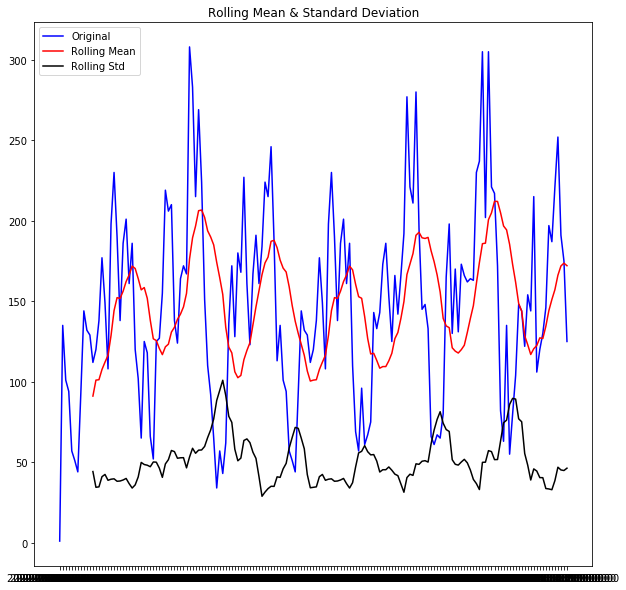

In [5]:
from statsmodels.tsa.stattools import adfuller as adf
import matplotlib.dates as mdates

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    plt.figure(figsize=(10,10)) # 更改圖片大小
    #Plot rolling statistics:
    orig = plt.plot(timeseries['number'], color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
test_stationarity(_df)

In [6]:
output = (adf(_df['number']))
output

(-6.020703223291623,
 1.4961638729534666e-07,
 14,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1574.3852847778514)

In [7]:
dfoutput = pd.Series(output[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in output[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -6.020703e+00
p-value                        1.496164e-07
#Lags Used                     1.400000e+01
Number of Observations Used    1.540000e+02
Critical Value (1%)           -3.473543e+00
Critical Value (5%)           -2.880498e+00
Critical Value (10%)          -2.576878e+00
dtype: float64


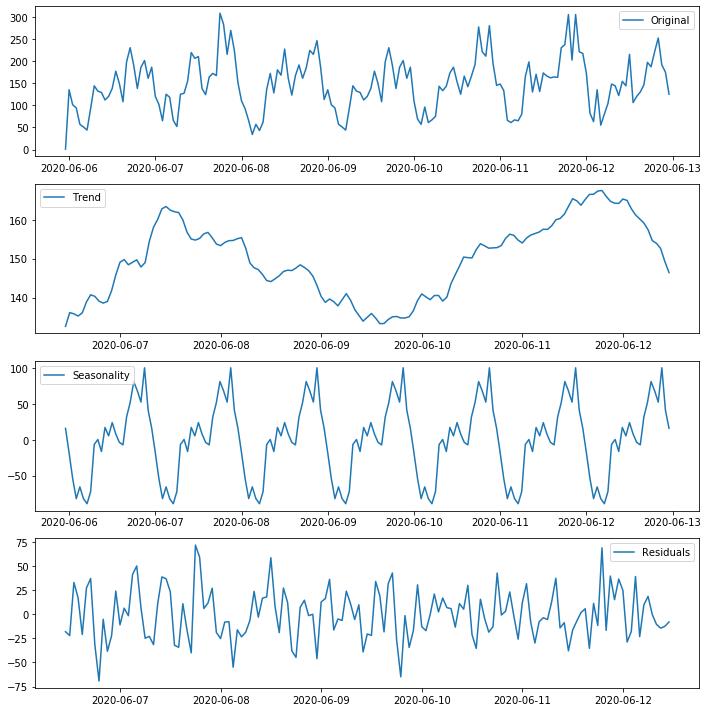

In [8]:
#estimating trend and seasonlity
from statsmodels.tsa.seasonal import seasonal_decompose

_df.index = pd.DatetimeIndex(_df['time'], freq='h')

decomposition = seasonal_decompose(_df['number'])
# decomposition.plot()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,10)) # 更改圖片大小

plt.subplot(411)
plt.plot(_df['number'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [9]:
import statsmodels.api as sm
import itertools
# Grid Search
p = d = q = range(0,3)                     # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q))       # gets all possible combinations of p, d, and q 
p2 = d2 = q2 = range(0, 2)                 # second set of p's, d's, and q's
pdq2 = list(itertools.product(p2,d2,q2))   # simular too code above but for seasonal parameters
s = 6                                     # periodicty of the seasonal cycle
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
combs = {}
aics = []

# Grid Search Continued
for combination in pdq:
    for seasonal_combination in pdqs2:
        try:
            model = sm.tsa.statespace.SARIMAX(_df['number'],
                                              order=combination,
                                              seasonal_order=seasonal_combination,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            model = model.fit()
            combs.update({model.aic : [combination, seasonal_combination]})
            aics.append(model.aic)
            
        except:
            continue
            
best_aic = min(aics)

C:\Users\HP AY111TX\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\HP AY111TX\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\HP AY111TX\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\HP AY111TX\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\HP AY111TX\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

C:\Users\HP AY111TX\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


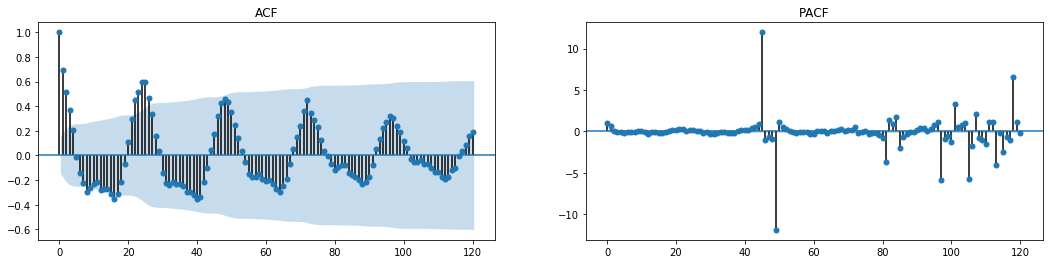

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def draw_acf_pacf(ts, lags=52):
    f = plt.figure(facecolor='white', figsize=(18,4))
    ax1 = f.add_subplot(121)
    plot_acf(ts, lags=lags, ax=ax1, title='ACF')
    ax2 = f.add_subplot(122)
    plot_pacf(ts, lags=lags, ax=ax2, title='PACF')
    plt.show
draw_acf_pacf(_df['number'], lags=120)

                                      SARIMAX Results                                      
Dep. Variable:                              number   No. Observations:                  169
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 6)   Log Likelihood                -794.459
Date:                             Mon, 12 Oct 2020   AIC                           1600.918
Time:                                     13:11:37   BIC                           1619.139
Sample:                                 06-05-2020   HQIC                          1608.319
                                      - 06-12-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7751      0.059     30.027      0.000       1.659       1.891
ar.L2         -0.8541      

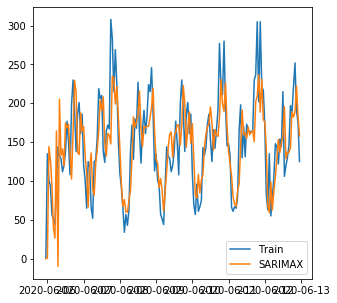

In [11]:
# Modeling and forcasting
model = sm.tsa.statespace.SARIMAX(_df['number'],
                                  order=combs[best_aic][0],
                                  seasonal_order=combs[best_aic][1],
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
model_fit = model.fit()
print(model_fit.summary())
pred = model_fit.predict(start=_df['number'].index[0], end=_df['number'].index[-1])

plt.figure(figsize=(5,5)) # 更改圖片大小

axes = plt.gca()
# axes.set_ylim([0, 4000])
plt.plot(_df['number'].index, _df['number'], label='Train')
plt.plot(pred.index, pred, label='SARIMAX')
plt.legend(loc='best')

In [13]:
import math
from sklearn.metrics import mean_squared_error

rms = math.sqrt(mean_squared_error(_df['number'], pred))
print(rms)

44.568752483621566
